In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Quote from this notebook:
https://www.kaggle.com/code/krishnakalyan3/pneumonia-fastai-2-0-baseline

## Highlights

 - An artificial intelligence system using transfer learning techniques was developed
 - It effectively classified images for macular degeneration and diabetic retinopathy
 - It also accurately distinguished bacterial and viral pneumonia on chest X-rays
 - This has potential for generalized high-impact application in biomedical imaging

## [Summary](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5)

- Challenge: The implementation of clinical-decision support algorithms for medical imaging faces challenges with reliability and interpretability.
 - Solution: A deep-learning framework for the screening of patients with common treatable blinding retinal diseases.
 - Benefits:
    + The framework utilizes transfer learning, which trains a neural network with a fraction of the data of conventional approaches.
    + This approach is comparable to that of human experts in classifying age-related macular degeneration and diabetic macular edema.
    + The diagnosis is more transparent and interpretable by highlighting the regions recognized by the neural network.
    + The AI system can be used to diagnose pediatric pneumonia using chest X-ray images.
 - Implication: This tool may ultimately aid in expediting the diagnosis and referral of these treatable conditions, thereby facilitating earlier treatment, resulting in improved clinical outcomes.

## Content

The dataset is organized into **3 folders (train, test, val)** and contains subfolders for each image category **(Pneumonia/Normal)**. There are 5,863 X-Ray images **(JPEG)** and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

## Code

In [2]:
import random, os
import numpy as np
import torch
from fastai.vision.all import *
from fastai.data.all import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [4]:
pneumonia_source = Path('/kaggle/input/chest-xray-pneumonia/chest_xray/'); 
list(pneumonia_source.ls())

[Path('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray'),
 Path('/kaggle/input/chest-xray-pneumonia/chest_xray/__MACOSX'),
 Path('/kaggle/input/chest-xray-pneumonia/chest_xray/val'),
 Path('/kaggle/input/chest-xray-pneumonia/chest_xray/test'),
 Path('/kaggle/input/chest-xray-pneumonia/chest_xray/train')]

In [5]:
# Randomly pick one image, .jpeg format
train_files = get_image_files(pneumonia_source/'train')
train_files[18]

Path('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1689_bacteria_4472.jpeg')

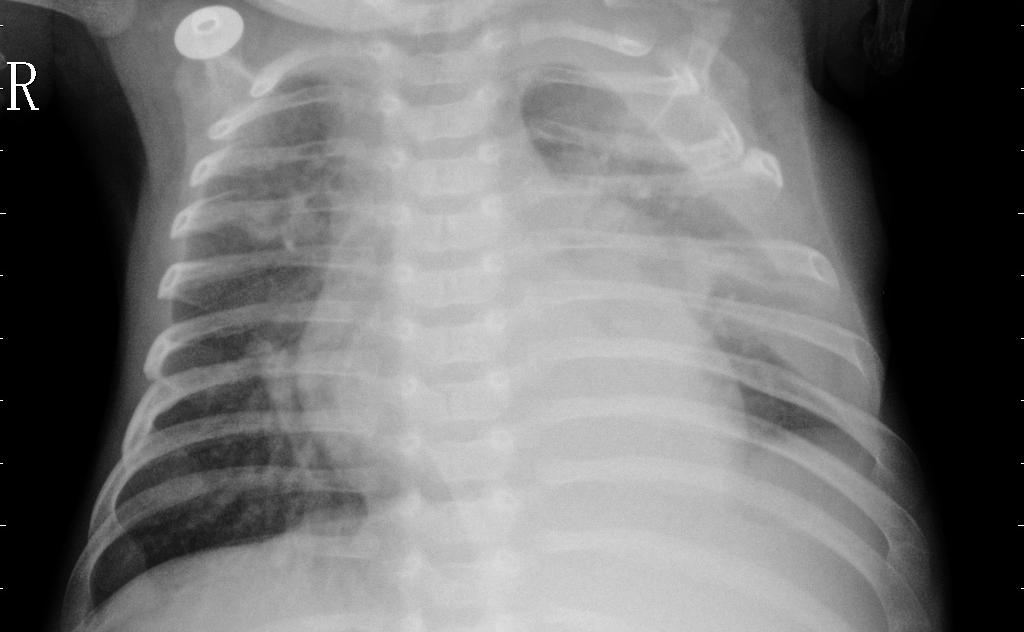

In [6]:
img = load_image(str(train_files[18]))
img

In [7]:
img.shape

(632, 1024)

In [8]:
dls = ImageDataLoaders.from_folder(
    pneumonia_source, 
    train = 'train',
    valid='val',
    bs = 64,
    seed = 0,
    item_tfms = Resize(460),
    batch_tfms = [*aug_transforms(
                                    size=224, max_warp=0.2, p_lighting=0.75,
                                    do_flip=True
                  ),
                  Normalize.from_stats(*imagenet_stats)]
    )

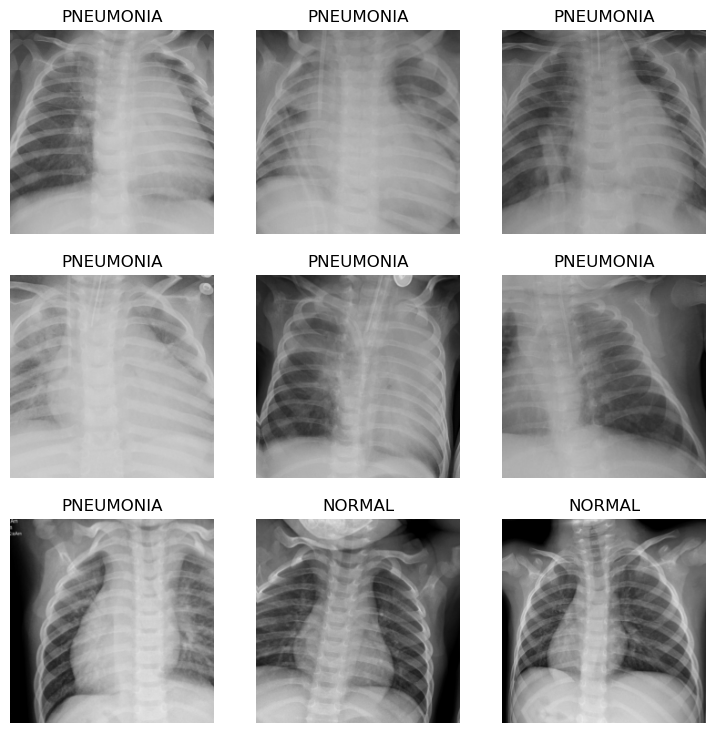

In [9]:
dls.show_batch()

In [10]:
# Find out label
print(dls.vocab); print(dls.c)

['NORMAL', 'PNEUMONIA']
2


In [11]:
os.getcwd()

'/kaggle/working'

In [12]:
learn = vision_learner(
    dls, resnet34, 
    pretrained = True,
    loss_func=CrossEntropyLossFlat(),
    metrics = accuracy,
    model_dir = '/kaggle/working/',
).to_fp16()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 54.1MB/s]


SuggestedLRs(valley=0.0012022644514217973)

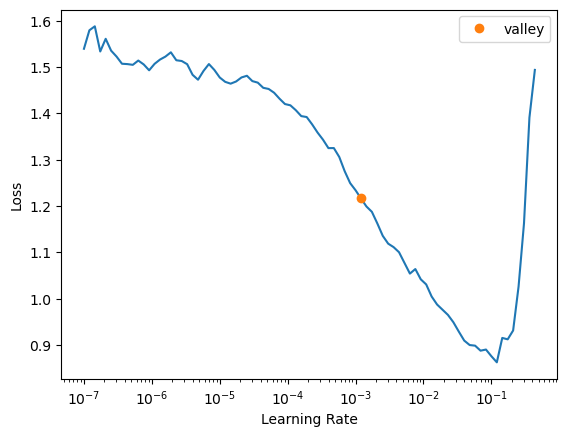

In [13]:
learn.lr_find()

In [14]:
learn.fine_tune(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.580383,0.387984,0.875000,01:51


epoch,train_loss,valid_loss,accuracy,time
0,0.224278,0.175188,0.937500,01:52
